# Segmentation of fluorescence images

In [1]:
import pandas as pd
import numpy as np
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import skimage.feature
import os

from spatial_tools.image.manipulate import crop_img
from spatial_tools.image.tools import read_tif

# path to "raw" dataset folder
BASE_PATH = "../../data"
dataset_name = "V1_Adult_Mouse_Brain_Coronal_Section_2"
dataset_folder = os.path.join(
    BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla"
)

In [2]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

xcoord = adata.obsm["spatial"][:, 0]
ycoord = adata.obsm["spatial"][:, 1]
spot_diameter = adata.uns['spatial'][dataset_name]['scalefactors']['spot_diameter_fullres']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
img = read_tif(dataset_folder, dataset_name, )

## Blob detection

In [4]:
def kernel_segmentation(
    X, 
    method="log", 
    channel_id=0, 
    smooth=False,
    min_sigma=10,
    max_sigma=50,
    num_sigma=20,
    threshold=10,
    sigma_smoothing=1.,
):
    fig, axes = plt.subplots(1,5, figsize=(25,5))
    axes[0].imshow(X)
    if smooth:
        X_mod = skimage.filters.gaussian(
            X, sigma=sigma_smoothing, output=None, mode='nearest', cval=0, 
            multichannel=None, preserve_range=False, truncate=3*sigma_smoothing
        )
        #X_mod = skimage.exposure.equalize_hist(X, nbins=256, mask=None)
    else:
        X_mod = X
    axes[1].imshow(X_mod)
    axes[2].imshow(X_mod[:,:,0])
    axes[3].imshow(X_mod[:,:,1])
    axes[4].imshow(X_mod[:,:,2])

    if method == "log":
        blobs = skimage.feature.blob_log(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            num_sigma=num_sigma, 
            threshold=threshold,
            overlap=0.5,
            log_scale=False, 
            exclude_border=False
        )
    elif method == "dog":
        blobs = skimage.feature.blob_dog(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma, 
            threshold=threshold,
            sigma_ratio=1.6, 
            overlap=1.,
            exclude_border=False
        )
    else:
        blobs = skimage.feature.blob_doh(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            num_sigma=num_sigma, 
            threshold=threshold,
            overlap=0.5, 
            log_scale=False
        )
    fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
    ax = [axes]
    #ax = axes.ravel()

    idx = 0
    ax[idx].imshow(X)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=True)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()
    return blob

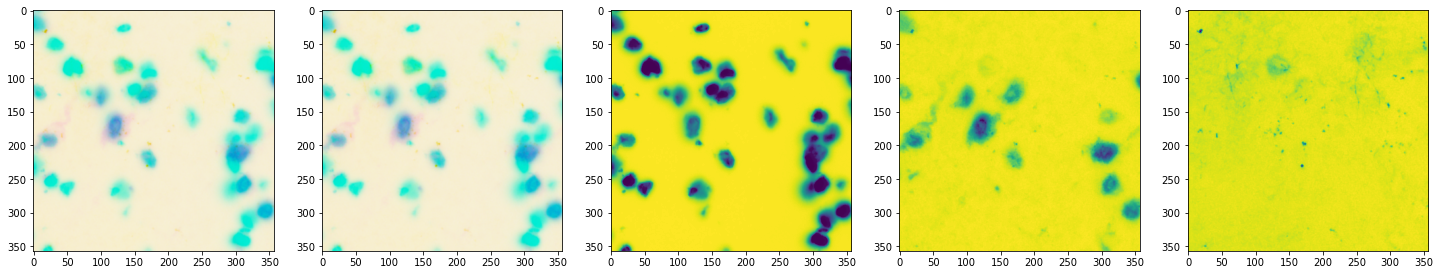

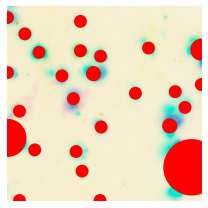

In [5]:
spot_id = 0
crop = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=2, spot_diameter=spot_diameter)
   
blobs = kernel_segmentation(X=255-crop, method="log", channel_id=0, smooth=False)

## Watershed

In [6]:
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [7]:
# get binarized image
thresh = threshold_otsu(crop[:,:,0])
mask = crop[:,:,0] < thresh

# calculate markers as maximal distanced points from background (locally)
distance = ndi.distance_transform_edt(1-mask)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)),
                            labels=1-mask)
markers = ndi.label(local_maxi)[0]
print(markers.max())

55


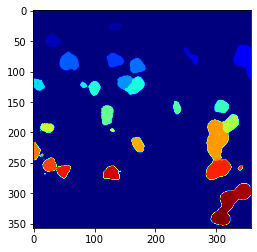

In [8]:
# label image with watershed
labelled = watershed(255-crop[:,:,0], markers, mask=1-mask)

plt.imshow(labelled, cmap='jet')